# Предварительная настройка

Импорт библиотек

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import random
from torchsummary import summary
from pandas import DataFrame
import seaborn as sn

Обращение к Google Диску из Google Colab 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Настройка начального значения для воспроизводимости результатов

In [3]:
def init_random_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

random_seed = 17
init_random_seed(random_seed)

Использование GPU в вычислениях

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Датасет

Название папки с картинками и путь до нее на Google диске

In [5]:
NAME = 'architecture'
data_dir = '/content/drive/My Drive/' + NAME

Аугментация и нормализация исходных картинок

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Создание датасета

In [7]:
image_datasets = {x: 
                 datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                 for x in ['train', 'test']}
                 
dataloaders = {x: 
              torch.utils.data.DataLoader(image_datasets[x], batch_size = 6, shuffle = True, num_workers = 6)
              for x in ['train', 'test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Информация о датасете (размер, классы)

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print('dataset_sizes:', dataset_sizes)

class_names = image_datasets['train'].classes
print('\nclass_names:', class_names)

dataset_sizes: {'train': 262, 'test': 49}

class_names: ['ар-деко', 'барокко', 'византийский', 'готика', 'романский']


Отображение части датасета

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


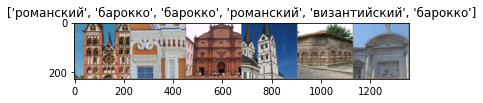

In [17]:
def imshow(image, title = None):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title is not None:
       plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

image, classes = next(iter(dataloaders['train']))
grid = torchvision.utils.make_grid(image)
imshow(grid, title = [class_names[x] for x in classes])

# Нейронная сеть

Создание нейронной сети на основе обученной Resnet34

In [10]:
model = models.resnet34(pretrained = True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 5, gamma = 0.1)

Функция для обучения сети

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, since):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_acc = 0.0
    best_loss = sys.maxsize

    hist_loss_train = []
    hist_acc_train = []
    hist_loss_test = []
    hist_acc_test = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs), '\n', '-'*10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
               
                optimizer.zero_grad()
              
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).cpu()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc)
            else:     
                hist_loss_test.append(epoch_loss)
                hist_acc_test.append(epoch_acc)

            if phase == 'test' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    model.eval()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best epoch:{}  TestLoss:{:4f}  Acc: {:4f}'.format(best_epoch, best_loss, best_acc))
    
    hist_loss_train = [i * 100 for i in hist_loss_train]
    hist_loss_test = [i * 100 for i in hist_loss_test]
    plt.plot(np.arange(0, num_epochs), hist_loss_train, label = 'hist_loss_train')
    plt.plot(np.arange(0, num_epochs), hist_loss_test, label = 'hist_loss_test')
    plt.legend(framealpha = 1, frameon = True)
    plt.title('График функции потерь CrossEntropyLoss')
    plt.xlabel("эпоха")
    plt.ylabel("значение, %")
    plt.show()

    hist_acc_train = [i * 100 for i in hist_acc_train]
    hist_acc_test = [i * 100 for i in hist_acc_test]
    plt.plot(np.arange(0, num_epochs), hist_acc_train, label = 'hist_acc_train')
    plt.plot(np.arange(0, num_epochs), hist_acc_test, label = 'hist_acc_test')
    plt.legend(framealpha = 1, frameon = True)
    plt.title('График точности классификации')
    plt.xlabel("эпоха")
    plt.ylabel("значение, %")
    plt.show()

    model.load_state_dict(best_model_wts)

    return model

Обучение сети

Epoch 1/20 
 ----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.5154 Acc: 0.3206
test Loss: 1.0127 Acc: 0.6735

Epoch 2/20 
 ----------
train Loss: 1.1321 Acc: 0.5305
test Loss: 0.6993 Acc: 0.7755

Epoch 3/20 
 ----------
train Loss: 0.8868 Acc: 0.6794
test Loss: 0.5265 Acc: 0.8367

Epoch 4/20 
 ----------
train Loss: 0.8241 Acc: 0.7061
test Loss: 0.4848 Acc: 0.8367

Epoch 5/20 
 ----------
train Loss: 0.7537 Acc: 0.7099
test Loss: 0.3810 Acc: 0.8980

Epoch 6/20 
 ----------
train Loss: 0.5748 Acc: 0.8092
test Loss: 0.3596 Acc: 0.8980

Epoch 7/20 
 ----------
train Loss: 0.6162 Acc: 0.7939
test Loss: 0.3671 Acc: 0.9184

Epoch 8/20 
 ----------
train Loss: 0.6618 Acc: 0.7557
test Loss: 0.3753 Acc: 0.8980

Epoch 9/20 
 ----------
train Loss: 0.6149 Acc: 0.7939
test Loss: 0.3526 Acc: 0.9184

Epoch 10/20 
 ----------
train Loss: 0.5704 Acc: 0.8473
test Loss: 0.3616 Acc: 0.8980

Epoch 11/20 
 ----------
train Loss: 0.5709 Acc: 0.8321
test Loss: 0.3443 Acc: 0.9184

Epoch 12/20 
 ----------
train Loss: 0.5592 Acc: 0.8168
test Loss: 0.3560 Ac

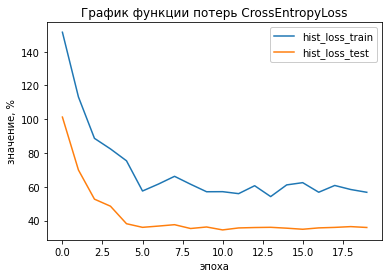

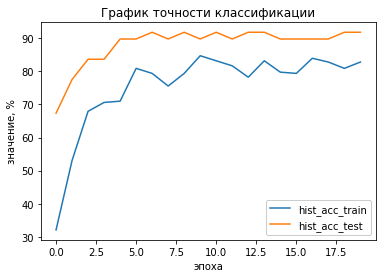

In [12]:
start_time = time.time()
num_epochs = 20
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = num_epochs, since = start_time)

# Итоги

Графическое отображение точности классификации архитектурных стилей обученной моделью на тепловой карте

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


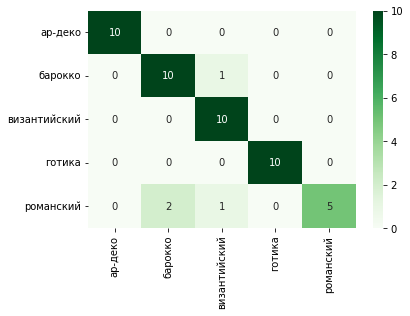

In [13]:
true_labels = []
pred_labels = []
for inputs, labels in dataloaders['test']:
  pred = model.forward(inputs.to(device)) 
  _,pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm = metrics.confusion_matrix(true_labels,pred_labels)
df_cm = DataFrame(cm, index = class_names, columns = class_names)
ax = sn.heatmap(df_cm, cmap = 'Greens', annot = True)

Сохранение обученной сети на Google Drive

In [15]:
model.eval()
model = model.to(torch.device("cpu"))
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model,input_tensor)
script_model.save("/content/drive/My Drive/"+NAME+".pt")

In [14]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
!nvidia-smi

Fri Jun 24 11:06:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |   1596MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------